# 3D ResNet18 (30 animal classes)

In [1]:
#%%python3 -m pip install --upgrade pip

In [2]:
%pip install mediapipe=='0.10.9'
%pip install opencv-python=='4.8.0.76'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import sys
sys.path.append("..")
from train_utils import VideoDataset, validate_model, validate_model_batched, train_model, display_frames

2024-02-23 13:53:05.618788: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 13:53:06.903958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 13:53:10.432758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [6]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [7]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

save = True

annotations_file = "/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DF_SHORT.tsv" # "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #
dataloader_dir =  "/home/jupyter/mnt/s3/rsl-videos/slovo/Dataloaders/animals/" #"/content/drive/MyDrive/slovo/dataloaders/"

train_dataloader_name = 'color_frames_train_dataloader.pth'
val_dataloader_name = 'color_frames_val_dataloader.pth'

save_path = "/home/jupyter/mnt/s3/rsl-videos/slovo/models/animals/resnet18" #'/content/drive/MyDrive/slovo/models/ResNet18' #'/content/model'

In [8]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,Unnamed: 0,attachment_id,text,begin,end,group_rank,dataset
595,55,25b5fb58-46dd-4fd6-9928-734460795b22,мышь,22,83,20,test
596,56,336e0e7a-ff68-427c-9a77-52626b81edd1,паук,42,74,19,test
597,57,d0ec4c00-6ff5-4089-ac9d-5a33a76fb037,паук,3,70,20,test
598,58,59ae408b-f87a-422a-bc57-2ff5af28ee57,бабочка,2,74,19,test
599,59,e421d77c-1dcd-4124-b2a4-b2415569a4dd,бабочка,63,131,20,test


In [9]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 30. Example classes: ('пингвин', 'жираф', 'лягушка', 'бегемот', 'козел')


In [10]:
train_dataloader = torch.load(dataloader_dir + train_dataloader_name)
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + val_dataloader_name)
print(f"Val dataloader contains: {len(val_dataloader)} videos")

Train dataloader contains: 480 videos
Val dataloader contains: 60 videos


In [11]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


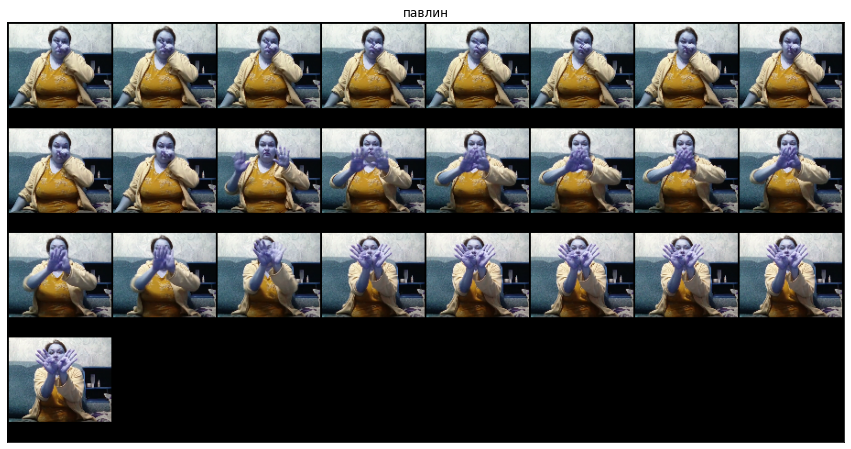

In [12]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [13]:
frames, labels = next(iter(val_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([29])


In [14]:
bs=1

# ResNet 18, $lr = 10^{-4}$

In [21]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=512, out_features=30, bias=True)

In [22]:
lr_power = -4
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet18_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [23]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.5909; val acc=0.033
Train Epoch 2/30: train_loss=3.459; val acc=0.033
Train Epoch 3/30: train_loss=3.4499; val acc=0.033
Train Epoch 4/30: train_loss=3.4578; val acc=0.033
Train Epoch 5/30: train_loss=3.4522; val acc=0.033
Train Epoch 6/30: train_loss=3.4524; val acc=0.033
Train Epoch 7/30: train_loss=3.4497; val acc=0.033
Train Epoch 8/30: train_loss=3.4457; val acc=0.033
Train Epoch 9/30: train_loss=3.5051; val acc=0.033
Train Epoch 10/30: train_loss=3.4424; val acc=0.033
Train Epoch 11/30: train_loss=3.4375; val acc=0.033
Train Epoch 12/30: train_loss=3.4309; val acc=0.033
Train Epoch 13/30: train_loss=3.4896; val acc=0.033
Train Epoch 14/30: train_loss=3.4184; val acc=0.033
Train Epoch 15/30: train_loss=3.4112; val acc=0.033
Train Epoch 16/30: train_loss=3.407; val acc=0.033
Train Epoch 17/30: train_loss=3.4055; val acc=0.033
Train Epoch 18/30: train_loss=3.4046; val acc=0.033
Train Epoch 19/30: train_loss=3.4037; val acc=0.033
Train Epoch 20/30: trai

# ResNet 18, $lr = 10^{-5}$

In [24]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=512, out_features=30, bias=True)

In [25]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet18_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [26]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.4562; val acc=0.033
Train Epoch 2/30: train_loss=3.4486; val acc=0.033
Train Epoch 3/30: train_loss=3.4154; val acc=0.033
Train Epoch 4/30: train_loss=3.4094; val acc=0.033
Train Epoch 5/30: train_loss=3.4124; val acc=0.050
Train Epoch 6/30: train_loss=3.4085; val acc=0.033
Train Epoch 7/30: train_loss=3.4084; val acc=0.017
Train Epoch 8/30: train_loss=3.3916; val acc=0.033
Train Epoch 9/30: train_loss=3.222; val acc=0.150
Train Epoch 10/30: train_loss=2.7116; val acc=0.283
Train Epoch 11/30: train_loss=1.833; val acc=0.517
Train Epoch 12/30: train_loss=0.9887; val acc=0.467
Train Epoch 13/30: train_loss=0.5495; val acc=0.583
Train Epoch 14/30: train_loss=0.2695; val acc=0.650
Train Epoch 15/30: train_loss=0.183; val acc=0.633
Train Epoch 16/30: train_loss=0.0665; val acc=0.667
Train Epoch 17/30: train_loss=0.0183; val acc=0.700
Train Epoch 18/30: train_loss=0.003; val acc=0.683
Train Epoch 19/30: train_loss=0.0011; val acc=0.683
Train Epoch 20/30: train_

# ResNet 18, $lr = 10^{-6}$

In [27]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=512, out_features=30, bias=True)

In [28]:
lr_power = -6
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet18_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [29]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.465; val acc=0.067
Train Epoch 2/30: train_loss=3.4063; val acc=0.100
Train Epoch 3/30: train_loss=2.704; val acc=0.233
Train Epoch 4/30: train_loss=1.4179; val acc=0.333
Train Epoch 5/30: train_loss=0.4938; val acc=0.467
Train Epoch 6/30: train_loss=0.1625; val acc=0.400
Train Epoch 7/30: train_loss=0.0621; val acc=0.483
Train Epoch 8/30: train_loss=0.0256; val acc=0.467
Train Epoch 9/30: train_loss=0.0139; val acc=0.483
Train Epoch 10/30: train_loss=0.0085; val acc=0.467
Train Epoch 11/30: train_loss=0.0058; val acc=0.433
Train Epoch 12/30: train_loss=0.004; val acc=0.450
Train Epoch 13/30: train_loss=0.0029; val acc=0.483
Train Epoch 14/30: train_loss=0.0022; val acc=0.483
Train Epoch 15/30: train_loss=0.0017; val acc=0.467
Train Epoch 16/30: train_loss=0.0013; val acc=0.467
Train Epoch 17/30: train_loss=0.001; val acc=0.483
Train Epoch 18/30: train_loss=0.0008; val acc=0.500
Train Epoch 19/30: train_loss=0.0007; val acc=0.500
Train Epoch 20/30: train_

# Update batch_size to 4

In [30]:
bs = 4
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

4 4


# ResNet 18, $lr = 10^{-5}$ bs = 4

In [31]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=512, out_features=30, bias=True)

In [32]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet18_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [33]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.4087; val acc=0.200
Train Epoch 2/30: train_loss=1.9338; val acc=0.400
Train Epoch 3/30: train_loss=0.5352; val acc=0.683
Train Epoch 4/30: train_loss=0.0889; val acc=0.700
Train Epoch 5/30: train_loss=0.0914; val acc=0.700
Train Epoch 6/30: train_loss=0.0264; val acc=0.717
Train Epoch 7/30: train_loss=0.0042; val acc=0.800
Train Epoch 8/30: train_loss=0.001; val acc=0.800
Train Epoch 9/30: train_loss=0.0006; val acc=0.817
Train Epoch 10/30: train_loss=0.0004; val acc=0.817
Train Epoch 11/30: train_loss=0.0003; val acc=0.817
Train Epoch 12/30: train_loss=0.0003; val acc=0.817
Train Epoch 13/30: train_loss=0.0002; val acc=0.817
Train Epoch 14/30: train_loss=0.0002; val acc=0.817
Train Epoch 15/30: train_loss=0.0002; val acc=0.817
Train Epoch 16/30: train_loss=0.0002; val acc=0.817
Train Epoch 17/30: train_loss=0.0001; val acc=0.817
Train Epoch 18/30: train_loss=0.0001; val acc=0.817
Train Epoch 19/30: train_loss=0.0001; val acc=0.817
Train Epoch 20/30: tra

# ResNet 18, $lr = 10^{-6}$ bs = 4

In [34]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=512, out_features=30, bias=True)

In [35]:
lr_power = -6
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet18_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [36]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.4426; val acc=0.083
Train Epoch 2/30: train_loss=3.3312; val acc=0.083
Train Epoch 3/30: train_loss=3.0586; val acc=0.067
Train Epoch 4/30: train_loss=2.6457; val acc=0.150
Train Epoch 5/30: train_loss=2.0202; val acc=0.200
Train Epoch 6/30: train_loss=1.3409; val acc=0.267
Train Epoch 7/30: train_loss=0.7916; val acc=0.217
Train Epoch 8/30: train_loss=0.4294; val acc=0.267
Train Epoch 9/30: train_loss=0.2416; val acc=0.367
Train Epoch 10/30: train_loss=0.1393; val acc=0.333
Train Epoch 11/30: train_loss=0.0909; val acc=0.350
Train Epoch 12/30: train_loss=0.0597; val acc=0.300
Train Epoch 13/30: train_loss=0.0448; val acc=0.317
Train Epoch 14/30: train_loss=0.0338; val acc=0.333
Train Epoch 15/30: train_loss=0.0278; val acc=0.333
Train Epoch 16/30: train_loss=0.0237; val acc=0.350
Train Epoch 17/30: train_loss=0.0202; val acc=0.350
Train Epoch 18/30: train_loss=0.0179; val acc=0.350
Train Epoch 19/30: train_loss=0.0161; val acc=0.367
Train Epoch 20/30: tr

# Update batch_size to 8

In [37]:
bs = 8
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

8 8


# ResNet 18, $lr = 10^{-5}$ bs = 8

In [38]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=512, out_features=30, bias=True)

In [39]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet18_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [40]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.4409; val acc=0.100
Train Epoch 2/30: train_loss=1.9651; val acc=0.467
Train Epoch 3/30: train_loss=0.4103; val acc=0.550
Train Epoch 4/30: train_loss=0.1146; val acc=0.633
Train Epoch 5/30: train_loss=0.0577; val acc=0.583
Train Epoch 6/30: train_loss=0.0152; val acc=0.700
Train Epoch 7/30: train_loss=0.0015; val acc=0.700
Train Epoch 8/30: train_loss=0.0008; val acc=0.700
Train Epoch 9/30: train_loss=0.0006; val acc=0.717
Train Epoch 10/30: train_loss=0.0005; val acc=0.717
Train Epoch 11/30: train_loss=0.0004; val acc=0.717
Train Epoch 12/30: train_loss=0.0004; val acc=0.717
Train Epoch 13/30: train_loss=0.0003; val acc=0.717
Train Epoch 14/30: train_loss=0.0003; val acc=0.717
Train Epoch 15/30: train_loss=0.0003; val acc=0.717
Train Epoch 16/30: train_loss=0.0002; val acc=0.717
Train Epoch 17/30: train_loss=0.0002; val acc=0.717
Train Epoch 18/30: train_loss=0.0002; val acc=0.717
Train Epoch 19/30: train_loss=0.0002; val acc=0.717
Train Epoch 20/30: tr

# ResNet 18, $lr = 10^{-6}$ bs = 8

In [41]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=512, out_features=30, bias=True)

In [42]:
lr_power = -6
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet18_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [43]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.5091; val acc=0.033
Train Epoch 2/30: train_loss=3.3829; val acc=0.050
Train Epoch 3/30: train_loss=3.2158; val acc=0.083
Train Epoch 4/30: train_loss=3.0306; val acc=0.067
Train Epoch 5/30: train_loss=2.7306; val acc=0.100
Train Epoch 6/30: train_loss=2.278; val acc=0.100
Train Epoch 7/30: train_loss=1.7535; val acc=0.183
Train Epoch 8/30: train_loss=1.2658; val acc=0.200
Train Epoch 9/30: train_loss=0.8573; val acc=0.250
Train Epoch 10/30: train_loss=0.5928; val acc=0.283
Train Epoch 11/30: train_loss=0.4103; val acc=0.267
Train Epoch 12/30: train_loss=0.2719; val acc=0.233
Train Epoch 13/30: train_loss=0.2008; val acc=0.283
Train Epoch 14/30: train_loss=0.1487; val acc=0.283
Train Epoch 15/30: train_loss=0.1136; val acc=0.250
Train Epoch 16/30: train_loss=0.0913; val acc=0.267
Train Epoch 17/30: train_loss=0.076; val acc=0.250
Train Epoch 18/30: train_loss=0.0646; val acc=0.217
Train Epoch 19/30: train_loss=0.0569; val acc=0.250
Train Epoch 20/30: trai

# Update batch_size to 16

In [44]:
bs = 16
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

16 16


# ResNet 18, $lr = 10^{-5}$ bs = 16

In [45]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=512, out_features=30, bias=True)

In [46]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet18_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [47]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.4324; val acc=0.067
Train Epoch 2/30: train_loss=2.349; val acc=0.283
Train Epoch 3/30: train_loss=0.7181; val acc=0.383
Train Epoch 4/30: train_loss=0.1408; val acc=0.533
Train Epoch 5/30: train_loss=0.0342; val acc=0.583
Train Epoch 6/30: train_loss=0.0192; val acc=0.600
Train Epoch 7/30: train_loss=0.004; val acc=0.633
Train Epoch 8/30: train_loss=0.0019; val acc=0.667
Train Epoch 9/30: train_loss=0.0013; val acc=0.617
Train Epoch 10/30: train_loss=0.0011; val acc=0.617
Train Epoch 11/30: train_loss=0.0009; val acc=0.617
Train Epoch 12/30: train_loss=0.0008; val acc=0.600
Train Epoch 13/30: train_loss=0.0007; val acc=0.617
Train Epoch 14/30: train_loss=0.0006; val acc=0.617
Train Epoch 15/30: train_loss=0.0005; val acc=0.617
Train Epoch 16/30: train_loss=0.0005; val acc=0.617
Train Epoch 17/30: train_loss=0.0005; val acc=0.617
Train Epoch 18/30: train_loss=0.0004; val acc=0.617
Train Epoch 19/30: train_loss=0.0004; val acc=0.617
Train Epoch 20/30: trai

# ResNet 18, $lr = 10^{-6}$ bs = 16

In [48]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=512, out_features=30, bias=True)

In [49]:
lr_power = -6
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet18_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [50]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.5056; val acc=0.050
Train Epoch 2/30: train_loss=3.4152; val acc=0.050
Train Epoch 3/30: train_loss=3.3037; val acc=0.083
Train Epoch 4/30: train_loss=3.2095; val acc=0.100
Train Epoch 5/30: train_loss=3.0996; val acc=0.100
Train Epoch 6/30: train_loss=2.9495; val acc=0.117
Train Epoch 7/30: train_loss=2.7552; val acc=0.100
Train Epoch 8/30: train_loss=2.5037; val acc=0.100
Train Epoch 9/30: train_loss=2.2119; val acc=0.083
Train Epoch 10/30: train_loss=1.8818; val acc=0.117
Train Epoch 11/30: train_loss=1.5824; val acc=0.100
Train Epoch 12/30: train_loss=1.3019; val acc=0.083
Train Epoch 13/30: train_loss=1.0599; val acc=0.100
Train Epoch 14/30: train_loss=0.8716; val acc=0.083
Train Epoch 15/30: train_loss=0.73; val acc=0.100
Train Epoch 16/30: train_loss=0.6029; val acc=0.117
Train Epoch 17/30: train_loss=0.506; val acc=0.100
Train Epoch 18/30: train_loss=0.4328; val acc=0.133
Train Epoch 19/30: train_loss=0.3795; val acc=0.133
Train Epoch 20/30: train